In [467]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from typing import Optional, Dict, Any, Tuple
from sklearn import metrics
from collections import Counter
import math
from dataclasses import dataclass

sns.set_theme(style="darkgrid")

In [468]:
DATA_PATH = "../datasets/famcs_students.csv"

try:
    df = pd.read_csv(DATA_PATH)
    if df.empty:
        raise ValueError("Файл пустой")
except Exception as e:
    raise RuntimeError(f"Ошибка при загрузке данных: {e}")

df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [469]:
def open_df(df):
    import tempfile
    import sys
    import os
    import subprocess

    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")
    tmp_path = tmp.name
    tmp.close()

    df.to_csv(tmp_path, index=False)

    if sys.platform.startswith("win"):
        os.startfile(tmp_path)
    elif sys.platform.startswith("darwin"):
        subprocess.run(["open", tmp_path])
    else:
        subprocess.run(["xdg-open", tmp_path])


# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества


In [470]:
df.describe()

,cource,group,age,height,miss,foot_size,score
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,3.952756,6.118110,20.433071,178.751969,7.850394,41.953741,7.555433
std,0.213001,4.460789,1.394949,13.360222,8.716276,3.389107,1.460913
min,3.000000,1.000000,16.000000,100.000000,0.000000,34.125120,0.000000
25%,4.000000,2.000000,20.000000,170.000000,3.000000,39.000000,7.000000
50%,4.000000,4.000000,20.000000,179.000000,5.000000,42.000000,7.600000
75%,4.000000,11.000000,21.000000,187.000000,10.000000,45.000000,8.450000
max,4.000000,13.000000,30.000000,220.000000,40.000000,50.000000,10.000000


In [471]:
NUMERIC_THRESHOLD = 8

def identify_column_types(data: pd.DataFrame, threshold: int) -> dict[str, list[str]]:
    cols_to_check = data.select_dtypes(include=['int64', 'float64', 'object']).columns.tolist()
    
    col_types = {
        'binary': [],
        'ordinal_or_nominal': [],
        'continuous': []
    }

    for col in cols_to_check:
        unique_values = data[col].dropna().nunique()
        
        if unique_values == 2:
            col_types['binary'].append(col)
        elif 2 < unique_values <= threshold:
            col_types['ordinal_or_nominal'].append(col)
        elif unique_values > threshold:
            col_types['continuous'].append(col)
        else:
            if unique_values <= 1:
                print(f"Колонка '{col}' имеет {unique_values} уникальных значений и исключена.")

    all_identified_cols = set(col_types['binary'] + col_types['ordinal_or_nominal'] + col_types['continuous'])
    
    for col in data.select_dtypes(include=['int64', 'float64']).columns:
        if col not in all_identified_cols and col not in ['index']: # Исключаем служебные
            if data[col].dropna().nunique() > threshold:
                 col_types['continuous'].append(col)


    return col_types

column_types = identify_column_types(df, NUMERIC_THRESHOLD)

column_types['continuous'].remove('ai')
column_types['ordinal_or_nominal'].append('ai')

column_types

{'binary': ['cource',
  'sex',
  'ss',
  'interest',
  'weekend_study',
  'bad_sleep',
  'glasses',
  'anime',
  'study_form',
  'literature'],
 'ordinal_or_nominal': ['group',
  'stream',
  'age',
  'os',
  'work_experience',
  'social',
  'sport',
  'eye_color',
  'retake',
  'hostel',
  'ai'],
 'continuous': ['height', 'miss', 'foot_size', 'score']}

In [472]:
binary_cols = column_types['binary']
ordinal_or_nominal_cols = column_types['ordinal_or_nominal']
continuous_cols = column_types['continuous'] 

In [473]:
N = 20
target_index = N % 8
COL = binary_cols[target_index]

COL

'weekend_study'

In [474]:
non_continuous_cols = binary_cols + ordinal_or_nominal_cols

unique_values_map = {}

print("-" * 60)

for col in non_continuous_cols:
    unique_vals = df[col].dropna().unique().tolist()
    
    unique_values_map[col] = unique_vals
    
    print(f"| {col} | N={len(unique_vals)} | {unique_vals}")

print("-" * 60)

------------------------------------------------------------
| cource | N=2 | [4, 3]
| sex | N=2 | ['М', 'Ж']
| ss | N=2 | ['Нет', 'Да']
| interest | N=2 | ['Математика', 'Программирование']
| weekend_study | N=2 | ['Да', 'Нет']
| bad_sleep | N=2 | ['Да', 'Нет']
| glasses | N=2 | ['Нет', 'Да']
| anime | N=2 | ['Нет', 'Да']
| study_form | N=2 | ['Бюджет', 'Платная']
| literature | N=2 | ['Да', 'Нет']
| group | N=8 | [11, 8, 13, 2, 3, 4, 12, 1]
| stream | N=3 | ['Прикладная информатика', 'Прикладная математика', 'Информатика']
| age | N=6 | [20.0, 19.0, 21.0, 16.0, 22.0, 30.0]
| os | N=3 | ['MacOS', 'Windows', 'Linux']
| work_experience | N=4 | ['Меньше года', '1-2 года', 'Не работаю', 'более 2 лет']
| social | N=3 | ['Экстраверт', 'Интроверт', 'Социофоб']
| sport | N=3 | ['Редко, легкая физкультура', 'Да, я спортсмен', 'Вообще нет']
| eye_color | N=4 | ['Карие', 'Зеленые', 'Голубые', 'Серые']
| retake | N=3 | ['0', '1', '2+']
| hostel | N=3 | ['Нет, я из Минска', 'Нет, я из регионов', '

In [475]:
def check_missing_values(data: pd.DataFrame):
    missing_sum = data.isnull().sum()
    missing_info = missing_sum[missing_sum > 0]

    if not missing_info.empty:
        print("logger.warning: Обнаружены пропущенные значения:")
        print(missing_info)
    else:
        print("Пропущенных значений (NaN) не обнаружено.")

check_missing_values(df)

Пропущенных значений (NaN) не обнаружено.


In [476]:
def detect_outliers_iqr(series: pd.Series, threshold: float = 1.5) -> pd.Series:
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (series < lower_bound) | (series > upper_bound)

In [477]:
outlier_indices = pd.Index([])
numeric_for_outliers = continuous_cols + ['age']

for col in numeric_for_outliers:
    is_outlier = detect_outliers_iqr(df[col])
    outliers = df[is_outlier]
    if not outliers.empty:
        print("-" * 60)
        print(f"Обнаружено {len(outliers)} выбросов в '{col}':\n{outliers[col]}")
        outlier_indices = outlier_indices.union(outliers.index)

------------------------------------------------------------
Обнаружено 2 выбросов в 'height':
37    220.0
96    100.0
Name: height, dtype: float64
------------------------------------------------------------
Обнаружено 8 выбросов в 'miss':
30    40.0
31    40.0
33    30.0
38    25.0
43    40.0
53    34.0
73    40.0
96    39.5
Name: miss, dtype: float64
------------------------------------------------------------
Обнаружено 3 выбросов в 'score':
30    0.0
68    4.5
96    0.0
Name: score, dtype: float64
------------------------------------------------------------
Обнаружено 3 выбросов в 'age':
22    16.0
37    30.0
96    30.0
Name: age, dtype: float64


In [478]:
df = df.drop(labels=[96, 22, 37])

In [479]:
# label encoding

ordinal_mapping = {
    'work_experience': {'Не работаю': 0, 'Меньше года': 1, '1-2 года': 2, 'более 2 лет': 3},
    'sport': {'Вообще нет': 0, 'Редко, легкая физкультура': 1, 'Да, я спортсмен': 2},
    'retake': {'0': 0, '1': 1, '2+': 2},
    'hostel': {'Нет, я из Минска': 0, 'Нет, я из регионов': 1, 'Да': 2}
}

binary_str_mapping = {
    'cource': {3: 0, 4: 1},
    'sex': {'Ж': 0, 'М': 1},
    'ss': {'Нет': 0, 'Да': 1},
    'interest': {'Математика': 0, 'Программирование': 1},
    'weekend_study': {'Нет': 0, 'Да': 1},
    'bad_sleep': {'Нет': 0, 'Да': 1},
    'glasses': {'Нет': 0, 'Да': 1}, 
    'anime': {'Нет': 0, 'Да': 1},
    'study_form': {'Платная': 0, 'Бюджет': 1},
    'literature': {'Нет': 0, 'Да': 1},
}

full_mapping = {**binary_str_mapping, **ordinal_mapping}

In [480]:
for col, mapping in full_mapping.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)
        if df[col].dtype == 'object' and df[col].nunique() > 0:
            raise TypeError(f"Fail-fast: Колонка '{col}' все еще строковая после кодирования!")

/tmp/ipykernel_166362/3556101177.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping)


In [481]:
nominal_for_ohe = df.select_dtypes(include=['object']).columns.tolist()
nominal_for_ohe

['stream', 'os', 'ai', 'social', 'eye_color']

In [482]:
if nominal_for_ohe:
    df = pd.get_dummies(df, columns=nominal_for_ohe, prefix=nominal_for_ohe, drop_first=True)
    print(f"Проведен OHE для: {nominal_for_ohe}")
else:
    print("Номинальные строковые колонки для OHE не найдены.")

Проведен OHE для: ['stream', 'os', 'ai', 'social', 'eye_color']


In [483]:
df.select_dtypes(include=['int64', 'float64'])

,cource,group,sex,age,ss,interest,weekend_study,bad_sleep,glasses,work_experience,height,anime,sport,miss,study_form,foot_size,score,retake,hostel,literature
0,1,11,1,20.0,0,0,1,1,0,1,192.0,0,1,3.0,1,48.0,9.20,0,0,1
1,1,11,0,20.0,0,1,0,0,0,2,169.0,0,2,5.0,1,39.0,8.80,0,0,1
2,1,11,0,19.0,0,1,1,0,0,1,190.0,0,0,10.0,1,41.0,8.80,0,0,1
3,1,11,0,20.0,0,0,1,1,0,2,158.0,0,2,3.0,1,36.0,8.80,0,0,1
4,1,11,1,20.0,0,0,1,0,0,0,187.0,0,0,1.0,1,46.0,9.00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,1,1,20.0,0,1,0,0,1,0,185.0,1,0,1.0,1,45.0,6.29,0,0,1
123,1,1,0,22.0,0,1,1,1,1,0,169.0,0,1,0.0,1,39.0,6.00,0,1,0
124,1,1,1,21.0,0,0,0,0,1,0,183.0,0,2,10.0,1,44.0,7.00,0,0,0
125,1,1,1,20.0,0,1,1,1,0,2,187.0,1,2,1.0,1,45.0,7.00,0,1,0


In [484]:
ordinal_or_nominal_cols

['group',
 'stream',
 'age',
 'os',
 'work_experience',
 'social',
 'sport',
 'eye_color',
 'retake',
 'hostel',
 'ai']

In [485]:
scaling_cols = continuous_cols + ['age']
scaling_cols

['height', 'miss', 'foot_size', 'score', 'age']

In [486]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()

df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

print(f"Проведена стандартизация {len(scaling_cols)} колонок.")

Проведена стандартизация 5 колонок.


In [487]:
df[['work_experience', 'sport', 'retake', 'hostel']]

,work_experience,sport,retake,hostel
0,1,1,0,0
1,2,2,0,0
2,1,0,0,0
3,2,2,0,0
4,0,0,0,0
...,...,...,...,...
122,0,0,0,0
123,0,1,0,1
124,0,2,0,0
125,2,2,0,1


In [488]:
# open_df(df)

In [489]:
df.head()

,cource,group,sex,age,ss,interest,weekend_study,bad_sleep,glasses,work_experience,...,ai_Grok,ai_Mistral,ai_Qwen,ai_claude,ai_gpt oss 120b,social_Социофоб,social_Экстраверт,eye_color_Зеленые,eye_color_Карие,eye_color_Серые
0,1,11,1,-0.548752,0,0,1,1,0,1,...,False,False,False,False,False,False,True,False,True,False
1,1,11,0,-0.548752,0,1,0,0,0,2,...,False,True,False,False,False,False,True,True,False,False
2,1,11,0,-2.293501,0,1,1,0,0,1,...,False,False,False,False,False,False,True,False,True,False
3,1,11,0,-0.548752,0,0,1,1,0,2,...,False,False,True,False,False,False,True,False,True,False
4,1,11,1,-0.548752,0,0,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False


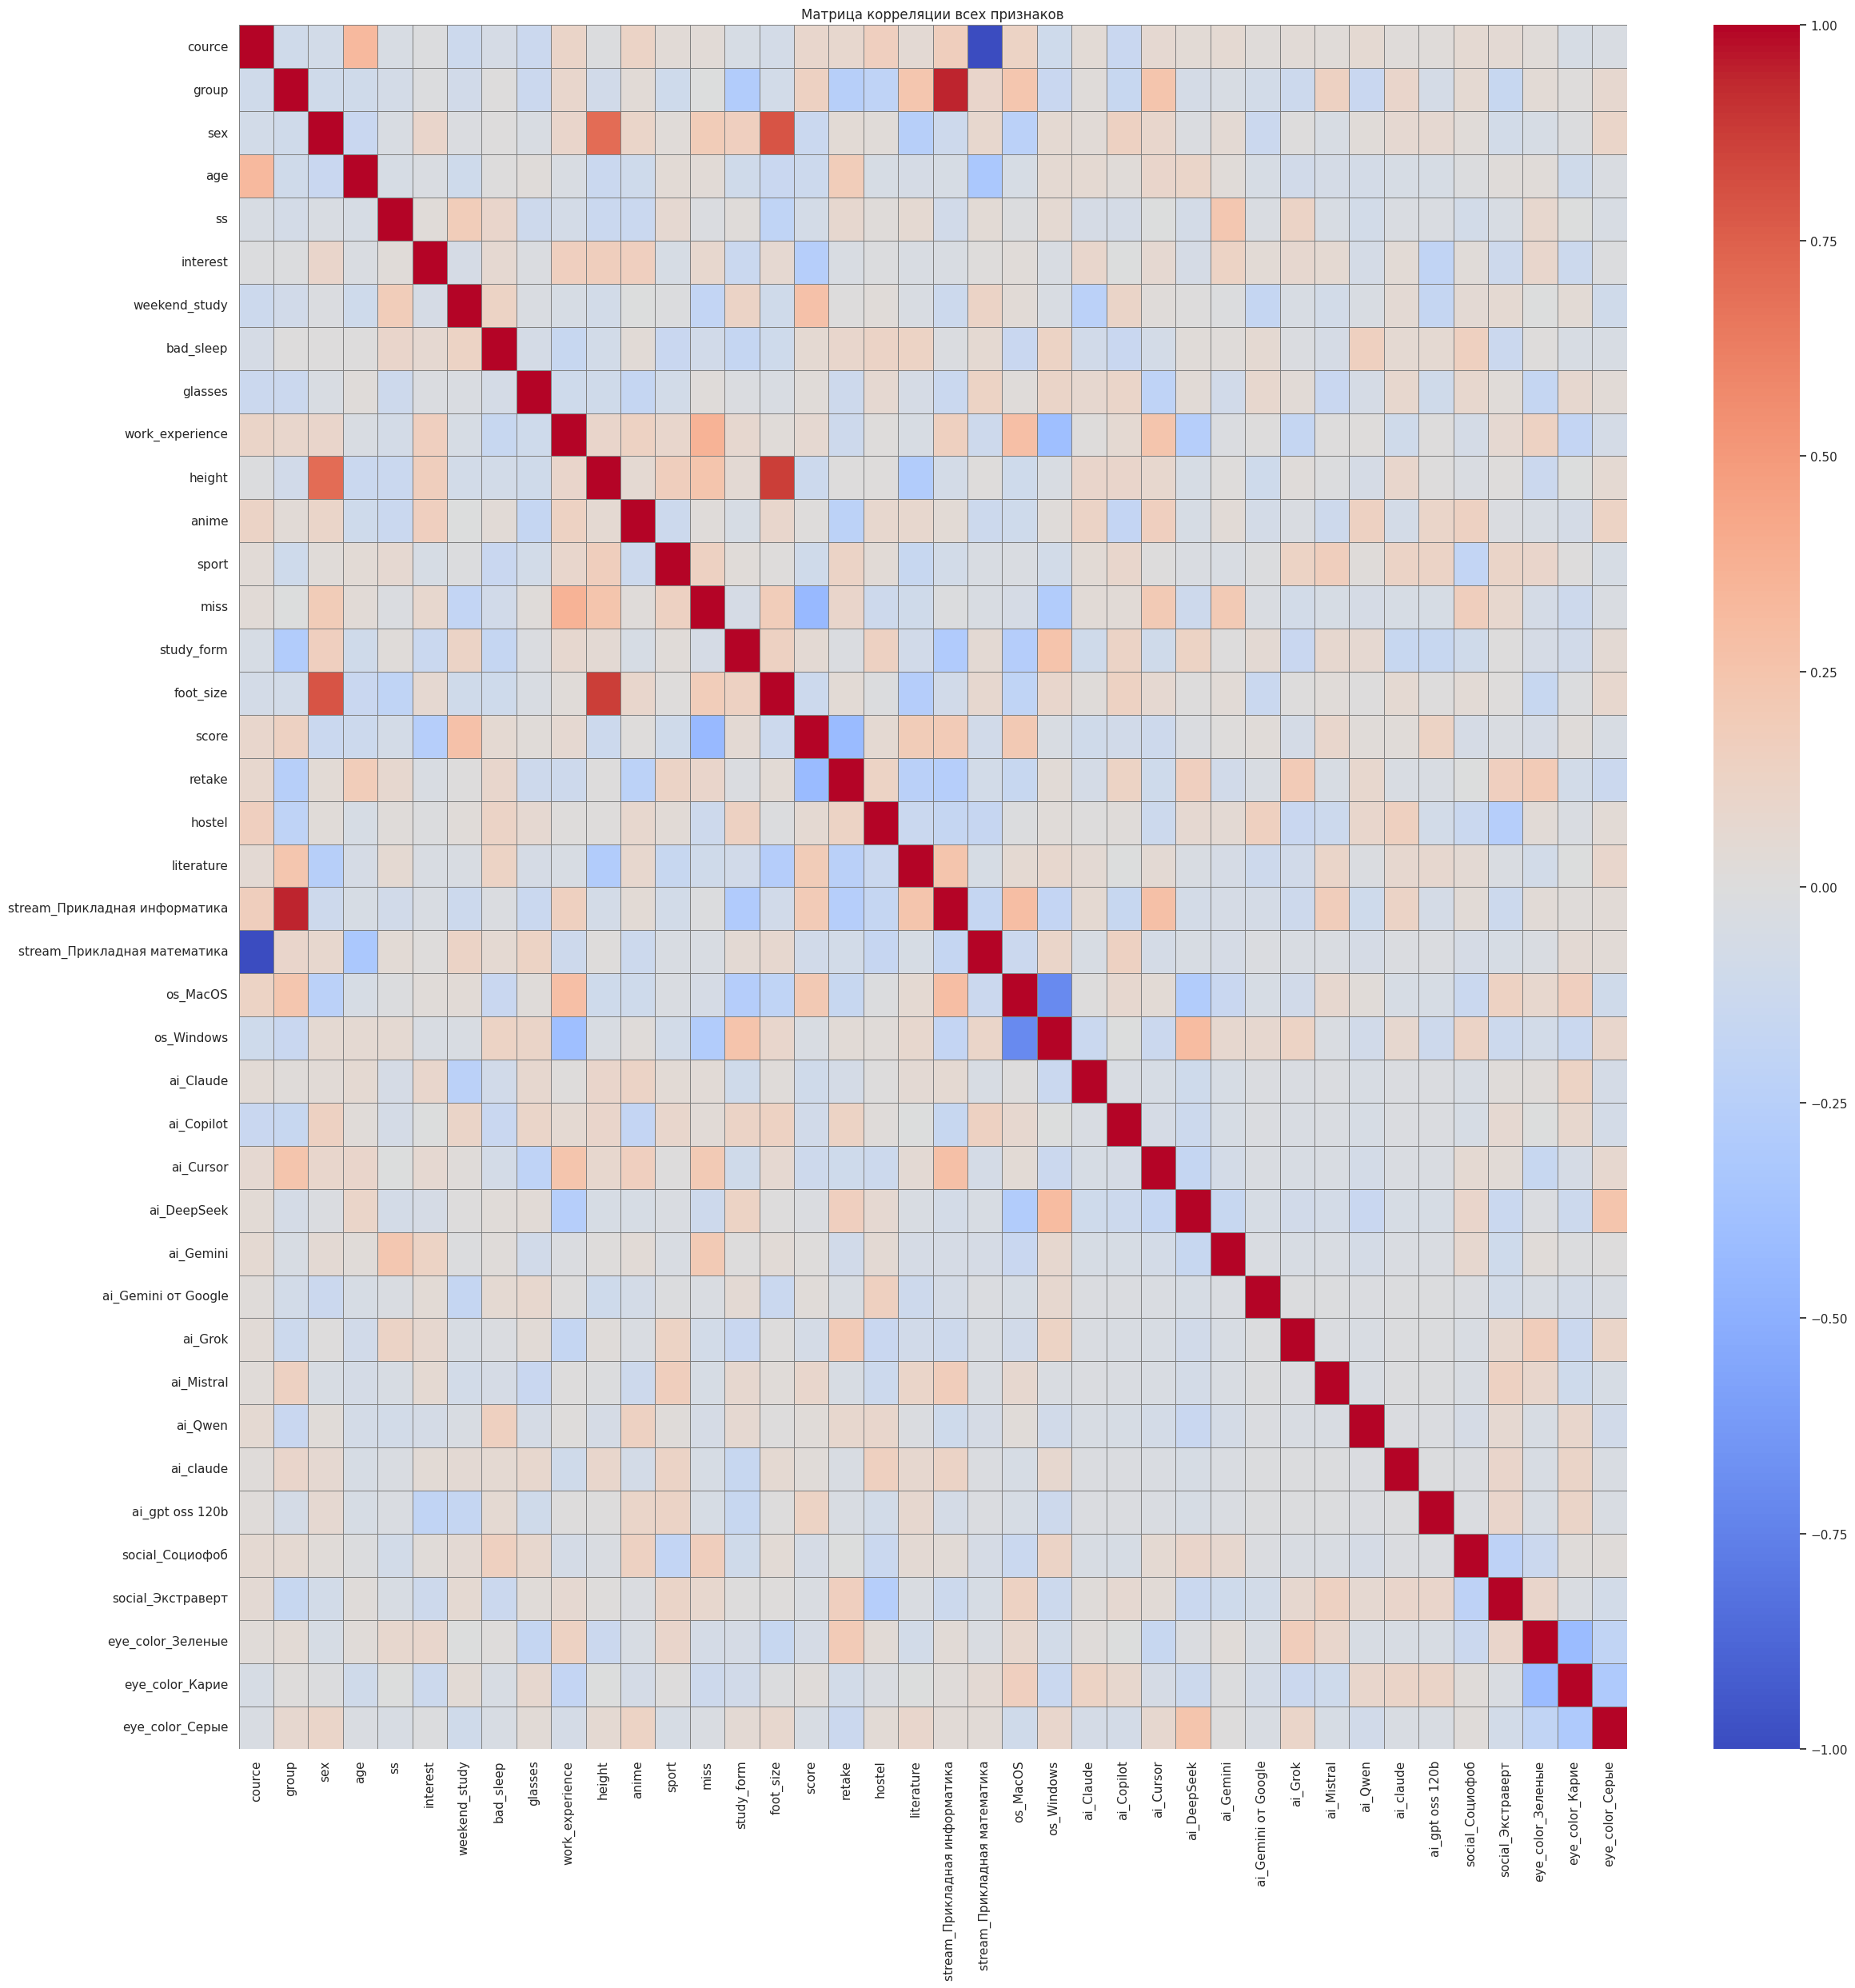

In [490]:
corr_mtx = df.corr()
P = corr_mtx.shape[0] 

scale = 0.7
figsize = (int(P * scale), int(P * scale))

plt.figure(figsize=figsize) 
sns.heatmap(corr_mtx, annot=False, cmap="coolwarm", 
            linewidths=0.5, linecolor='gray', 
            fmt=".2f") 
plt.title("Матрица корреляции всех признаков")
plt.show()

## -1. Split

In [491]:
binary_cols

['cource',
 'sex',
 'ss',
 'interest',
 'weekend_study',
 'bad_sleep',
 'glasses',
 'anime',
 'study_form',
 'literature']

In [492]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

COL = 'weekend_study'
X = df.drop(columns=[COL]).astype(float)
y = df[COL]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Размер X_train: {X_train.shape[0]} (70%)")
print(f"Размер X_val: {X_val.shape[0]} (15%)")
print(f"Размер X_test: {X_test.shape[0]} (15%)")

class_ratio = y_train.value_counts(normalize=True)
print(f"\nСоотношение классов в y_train:\n{class_ratio.round(2)}")

Размер X_train: 86 (70%)
Размер X_val: 19 (15%)
Размер X_test: 19 (15%)

Соотношение классов в y_train:
weekend_study
1    0.78
0    0.22
Name: proportion, dtype: float64


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс


In [493]:
def _ensure_1d(arr: np.ndarray) -> np.ndarray:
    a = np.asarray(arr)
    if a.ndim == 2 and a.shape[1] == 1:
        return a.ravel()
    if a.ndim != 1:
        raise ValueError("Labels must be 1-D array-like")
    return a


In [494]:
class TrivialClassifier:
    def __init__(self):
        self.most_common_: Optional[int] = None

    def fit(self, y: np.ndarray) -> "TrivialClassifier":
        y = _ensure_1d(np.asarray(y))
        if y.size == 0:
            raise ValueError("Empty labels provided to TrivialClassifier.fit")
        self.most_common_ = int(Counter(y).most_common(1)[0][0])
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.most_common_ is None:
            raise ValueError("Model not fitted")
        n = X.shape[0]
        return np.full(shape=(n,), fill_value=self.most_common_, dtype=int)

int(Counter(y).most_common(1)[0][0])

1

## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!


In [495]:
class GaussianNaiveBayes:
    """
    It accepts X as 2D numpy array and y as 1D integer labels.
    """
    def __init__(self, eps: float = 1e-9):
        self.eps = float(eps)
        self.classes_: Optional[np.ndarray] = None
        self.class_prior_: Dict[int, float] = {}
        self.mean_: Dict[int, np.ndarray] = {}
        self.var_: Dict[int, np.ndarray] = {}

    def fit(self, X: np.ndarray, y: np.ndarray) -> "GaussianNaiveBayes":
        X = np.asarray(X, dtype=float)
        y = _ensure_1d(np.asarray(y))
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        if X.ndim != 2:
            raise ValueError("X must be 2D")

        self.classes_, counts = np.unique(y, return_counts=True)
        for cls, cnt in zip(self.classes_, counts):
            idx = (y == cls)
            Xc = X[idx]
            if Xc.shape[0] == 0:
                raise ValueError(f"No samples for class {cls}")
            self.class_prior_[int(cls)] = float(cnt / y.shape[0])
            self.mean_[int(cls)] = np.mean(Xc, axis=0)
            # variance with ddof=0; add eps for numeric stability
            self.var_[int(cls)] = np.var(Xc, axis=0) + self.eps
        return self

    def _log_gaussian_prob(self, X: np.ndarray, mean: np.ndarray, var: np.ndarray) -> np.ndarray:
        # log of Gaussian probability (per feature); return sum over features
        # shape(X) = (n_samples, n_features)
        denom = np.sqrt(2 * math.pi * var)
        exponent = -0.5 * ((X - mean) ** 2) / var
        # sum log-probs across features
        return np.sum(exponent - np.log(denom), axis=1)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.classes_ is None:
            raise ValueError("Model not fitted")
        X = np.asarray(X, dtype=float)
        log_probs = []
        for cls in self.classes_:
            lp = np.log(self.class_prior_[int(cls)]) + \
                 self._log_gaussian_prob(X, self.mean_[int(cls)], self.var_[int(cls)])
            log_probs.append(lp)
        log_probs = np.vstack(log_probs).T  # shape (n_samples, n_classes)
        # convert log_probs to probabilities stably
        max_lp = np.max(log_probs, axis=1, keepdims=True)
        exp_lp = np.exp(log_probs - max_lp)
        probs = exp_lp / np.sum(exp_lp, axis=1, keepdims=True)
        return probs

    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1).astype(int)

## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.



In [496]:
class KNNClassifier:
    """
    k-NN classifier with Euclidean distance
    """
    def __init__(self, k: int = 3):
        if k < 1:
            raise ValueError("k must be >= 1")
        self.k = int(k)
        self.X_train: Optional[np.ndarray] = None
        self.y_train: Optional[np.ndarray] = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> "KNNClassifier":
        X = np.asarray(X, dtype=float)
        y = _ensure_1d(np.asarray(y)).astype(int)
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have same length")
        self.X_train = X.copy()
        self.y_train = y.copy()
        return self

    def _pairwise_distances(self, X: np.ndarray) -> np.ndarray:
        # Efficient squared euclidean distances: (a-b)^2 = a^2 + b^2 - 2ab
        a2 = np.sum(self.X_train**2, axis=1)[None, :]      # shape (1, n_train)
        b2 = np.sum(X**2, axis=1)[:, None]                 # shape (n_test, 1)
        ab = X @ self.X_train.T                            # shape (n_test, n_train)
        d2 = b2 + a2 - 2*ab
        # numerical issues
        d2 = np.maximum(d2, 0.0)
        return np.sqrt(d2)

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.X_train is None:
            raise ValueError("Not fitted")
        X = np.asarray(X, dtype=float)
        dists = self._pairwise_distances(X)  # (n_test, n_train)
        neigh_idx = np.argpartition(dists, kth=self.k-1, axis=1)[:, :self.k]  # unsorted neighbors
        # for each row, do majority vote
        preds = []
        for i in range(neigh_idx.shape[0]):
            labels = self.y_train[neigh_idx[i]]
            most = Counter(labels).most_common(1)[0][0]
            preds.append(int(most))
        return np.array(preds, dtype=int)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.X_train is None:
            raise ValueError("Not fitted")
        X = np.asarray(X, dtype=float)
        dists = self._pairwise_distances(X)
        neigh_idx = np.argpartition(dists, kth=self.k-1, axis=1)[:, :self.k]
        classes = np.unique(self.y_train)
        proba = np.zeros((X.shape[0], classes.size), dtype=float)
        for i in range(X.shape[0]):
            lbls = self.y_train[neigh_idx[i]]
            cnt = Counter(lbls)
            for j, cls in enumerate(classes):
                proba[i, j] = cnt.get(cls, 0) / self.k
        return proba

## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.



In [497]:
class LogisticRegressionScratch:
    """
    Multinomial logistic regression with gradient descent (softmax).
    For binary classification it reduces to sigmoid.
    """
    def __init__(self, lr: float = 1e-2, max_iter: int = 1000, tol: float = 1e-6, verbose: bool = False, l2: float = 0.0):
        self.lr = float(lr)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.verbose = bool(verbose)
        self.l2 = float(l2)
        self.W: Optional[np.ndarray] = None  # weights (n_features, n_classes)
        self.b: Optional[np.ndarray] = None  # biases (n_classes,)
        self.classes_: Optional[np.ndarray] = None

    def _one_hot(self, y: np.ndarray, n_classes: int) -> np.ndarray:
        oh = np.zeros((y.shape[0], n_classes), dtype=float)
        oh[np.arange(y.shape[0]), y] = 1.0
        return oh

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LogisticRegressionScratch":
        X = np.asarray(X, dtype=float)
        y = _ensure_1d(np.asarray(y)).astype(int)
        n_samples, n_features = X.shape
        self.classes_, _ = np.unique(y, return_counts=True)
        n_classes = self.classes_.shape[0]
        # map classes to 0..C-1
        cls_to_idx = {int(c): i for i, c in enumerate(self.classes_)}
        y_idx = np.array([cls_to_idx[int(v)] for v in y], dtype=int)

        # initialize
        rng = np.random.default_rng(0)
        W = rng.normal(scale=0.01, size=(n_features, n_classes))
        b = np.zeros(n_classes, dtype=float)

        y_onehot = self._one_hot(y_idx, n_classes)

        for it in range(self.max_iter):
            logits = X @ W + b  # (n_samples, n_classes)
            # numerical stability
            logits = logits - np.max(logits, axis=1, keepdims=True)
            exp_logits = np.exp(logits)
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)  # softmax
            grad_W = (X.T @ (probs - y_onehot)) / n_samples + self.l2 * W
            grad_b = np.mean(probs - y_onehot, axis=0)
            W_old = W.copy()

            W -= self.lr * grad_W
            b -= self.lr * grad_b

            # simple stopping criterion
            max_change = np.max(np.abs(W - W_old))
            if self.verbose and (it % 100 == 0 or it == self.max_iter - 1):
                loss = -np.mean(np.sum(y_onehot * np.log(np.clip(probs, 1e-12, 1.0)), axis=1))
                print(f"iter={it:4d} loss={loss:.6f} max_change={max_change:.6e}")
            if max_change < self.tol:
                if self.verbose:
                    print(f"Converged at iter={it}")
                break

        self.W = W
        self.b = b
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.W is None:
            raise ValueError("Model not fitted")
        X = np.asarray(X, dtype=float)
        logits = X @ self.W + self.b
        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probs

    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1).astype(int)


## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок
  



In [498]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray, y_proba: Optional[np.ndarray]=None) -> Dict[str, Any]:
    """
    Supports binary and multiclass.
    """
    y_true = _ensure_1d(np.asarray(y_true))
    y_pred = _ensure_1d(np.asarray(y_pred))

    unique_labels = np.unique(y_true)
    is_binary = unique_labels.shape[0] == 2

    if is_binary:
        avg = 'binary'
    else:
        avg = 'macro'

    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred, average=avg, zero_division=0)
    rec = metrics.recall_score(y_true, y_pred, average=avg, zero_division=0)
    f1 = metrics.f1_score(y_true, y_pred, average=avg, zero_division=0)

    if y_proba is not None:
        try:
            if is_binary:
                auc = metrics.roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
        except Exception:
            auc = float('nan')
    else:
        auc = float('nan')

    cm = metrics.confusion_matrix(y_true, y_pred)

    return {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(auc),
        "confusion_matrix": cm
    }

In [499]:
def tune_knn_k(X_train: np.ndarray, y_train: np.ndarray,
               X_val: np.ndarray, y_val: np.ndarray,
               k_values: list[int]) -> Tuple[int, Dict[int, float]]:
    """Tune k on validation set using macro F1 (works for binary/multiclass)."""
    best_k = None
    best_score = -1.0
    scores = {}
    for k in k_values:
        knn = KNNClassifier(k=k).fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        f1 = metrics.f1_score(y_val, y_pred, average='macro', zero_division=0)
        scores[k] = float(f1)
        if f1 > best_score:
            best_score = float(f1)
            best_k = k
    return int(best_k), scores

In [503]:
def plot_precision_recall_threshold(y_true, prob_pos):
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, prob_pos)
    
    # thresholds has length n-1; align it with precisions/recalls
    thr_plot = np.concatenate([thresholds, [1.0]])

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_threshold = thr_plot[best_idx]
    best_f1 = f1_scores[best_idx]

    plt.figure(figsize=(8,4))
    plt.plot(thr_plot, precisions, label="precision")
    plt.plot(thr_plot, recalls, label="recall")
    plt.plot(thr_plot, f1_scores, label="f1")
    plt.axvline(best_threshold, color='gray', linestyle='--')
    plt.legend()
    plt.show()

    return best_threshold, best_f1


In [504]:
@dataclass
class ModelResult:
    name: str
    y_true: np.ndarray
    y_pred: np.ndarray
    y_proba: Optional[np.ndarray] = None
    metrics: Optional[Dict[str, float]] = None
    conf_matrix: Optional[np.ndarray] = None

def run_all_models(X_train: np.ndarray, y_train: np.ndarray,
                   X_val: np.ndarray, y_val: np.ndarray,
                   X_test: np.ndarray, y_test: np.ndarray,
                   random_state: int = 0) -> Dict[str, ModelResult]:
    """
    Run trivial, GNB, knn (+ tune k), logistic; return results dict.
    Expects numeric X (np.ndarray) and integer y (np.ndarray).
    """
    results: Dict[str, ModelResult] = {}

    # Defensive checks
    for name, arr in (("X_train", X_train), ("y_train", y_train), ("X_val", X_val),
                      ("y_val", y_val), ("X_test", X_test), ("y_test", y_test)):
        if arr is None:
            raise ValueError(f"{name} is None")
    if X_train.shape[1] != X_val.shape[1] or X_train.shape[1] != X_test.shape[1]:
        raise ValueError("Feature dimension mismatch between train/val/test")

    # 0. trivial
    triv = TrivialClassifier().fit(y_train)
    y_pred = triv.predict(X_test)
    m0 = evaluate(y_test, y_pred)
    results["trivial"] = ModelResult("trivial", y_test, y_pred, y_proba=None, metrics=m0, conf_matrix=m0["confusion_matrix"])

    # 1. GaussianNB
    gnb = GaussianNaiveBayes().fit(X_train, y_train)
    proba_gnb = gnb.predict_proba(X_test)
    y_pred_gnb = np.argmax(proba_gnb, axis=1)
    m1 = evaluate(y_test, y_pred_gnb, proba_gnb)
    results["gnb"] = ModelResult("gnb", y_test, y_pred_gnb, y_proba=proba_gnb, metrics=m1, conf_matrix=m1["confusion_matrix"])

    # 2. k-NN: tune k on validation set
    max_k = min(51, max(1, X_train.shape[0] - 1))
    candidate_ks = [k for k in range(1, max_k+1, 2)]  # odd ks
    best_k, k_scores = tune_knn_k(X_train, y_train, X_val, y_val, candidate_ks)
    knn = KNNClassifier(k=best_k).fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    proba_knn = knn.predict_proba(X_test)
    m2 = evaluate(y_test, y_pred_knn, proba_knn)
    results["knn"] = ModelResult(f"knn_k{best_k}", y_test, y_pred_knn, y_proba=proba_knn, metrics=m2, conf_matrix=m2["confusion_matrix"])

    # 3. Logistic regression (train on train, optionally tune lr via grid on val - here keep simple)
    logreg = LogisticRegressionScratch(lr=1e-2, max_iter=5000, tol=1e-6, verbose=False, l2=1e-4)
    logreg.fit(X_train, y_train)
    proba_log = logreg.predict_proba(X_test)
    y_pred_log = logreg.predict(X_test)
    m3 = evaluate(y_test, y_pred_log, proba_log)
    results["logreg"] = ModelResult("logreg", y_test, y_pred_log, y_proba=proba_log, metrics=m3, conf_matrix=m3["confusion_matrix"])

    # If binary: use validation set to pick best threshold for logistic
    unique_train_labels = np.unique(y_train)
    if unique_train_labels.shape[0] == 2:
        pos_idx = 1  # assume label ordering 0/1; be careful in real code
        proba_val = logreg.predict_proba(X_val)[:, pos_idx]
        best_thr, best_f1 = plot_precision_recall_threshold(y_val, proba_val)
        # apply threshold on test positives
        y_pred_thresh = (proba_log[:, pos_idx] >= best_thr).astype(int)
        m3_thr = evaluate(y_test, y_pred_thresh, proba_log)
        results["logreg_thresholded"] = ModelResult(f"logreg_thr_{best_thr:.3f}", y_test, y_pred_thresh, y_proba=proba_log, metrics=m3_thr, conf_matrix=m3_thr["confusion_matrix"])

    return results

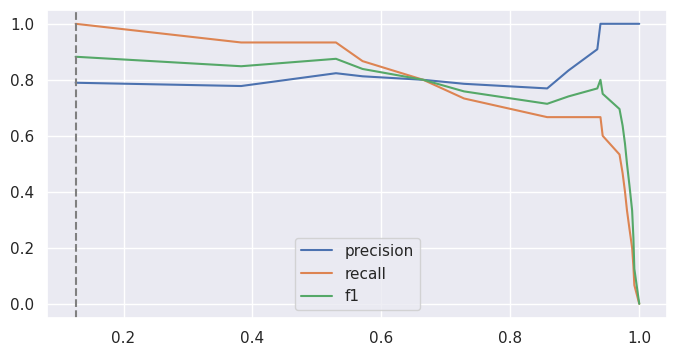

In [505]:
results = run_all_models(X_train=X_train, 
               y_train=y_train, 
               X_val=X_val, 
               y_val=y_val, 
               X_test=X_test, 
               y_test=y_test)

In [506]:
from pprint import pprint

rows = []
for name, model_result in results.items(): 
    model_result: ModelResult
    rows.append({
        "name": name,
        **model_result.metrics
    })

result_df = pd.DataFrame(rows)
#open_df(result_df)
pprint(result_df)

                 name  accuracy  precision    recall        f1   roc_auc  \
0             trivial  0.736842   0.736842  1.000000  0.848485       NaN   
1                 gnb  0.473684   0.833333  0.357143  0.500000  0.507143   
2                 knn  0.631579   0.705882  0.857143  0.774194  0.371429   
3              logreg  0.684211   0.750000  0.857143  0.800000  0.300000   
4  logreg_thresholded  0.736842   0.736842  1.000000  0.848485  0.300000   

    confusion_matrix  
0  [[0, 5], [0, 14]]  
1   [[4, 1], [9, 5]]  
2  [[0, 5], [2, 12]]  
3  [[1, 4], [2, 12]]  
4  [[0, 5], [0, 14]]  
